In [1]:
import torch
from torch import nn
import numpy as np
import scipy.io as sio

from data.dataset import get_data
from model.model import Transfollower

from config import Settings
import matplotlib.pyplot as plt

import plotly.graph_objects as go

In [7]:
settings = Settings()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

def val(model_name, data_name, batch_cnt = 0):
    # parameters
    SEQ_LEN = settings.SEQ_LEN
    LABEL_LEN = 40 if model_name == 'nn' else settings.LABEL_LEN
    PRED_LEN = settings.PRED_LEN
    T = settings.T # data sampling interval
    
    if model_name == 'transfollower':
        data_name += '_shift'

    # load model
    exp_name = f'{data_name}_{model_name}'
    save = f'checkpoints/{exp_name}_model.pt'
    with open(f'{save}', 'rb') as f:
        model = torch.load(f).to(device)
    model.eval()

    # get data loader
    if model_name == 'nn':
        _, _, data_loader = get_data(data_name = data_name, label_len = SEQ_LEN, shuffle = False, batch_size = 1)
    else:
        _, _, data_loader = get_data(data_name= data_name, shuffle = False, batch_size = 1)

    # evaluate

    with torch.no_grad():
        for i, item in enumerate(data_loader):
            if i == batch_cnt:
                if data_name == 'SH_shift':
                    enc_inp = item['his'][:,:, [0,1,4]].float().to(device)
                else:
                    enc_inp = item['his'].float().to(device)

                batch_y = item['svSpd'].float()
                y_label = batch_y[:,-PRED_LEN:,:].to(device)
                batch_y_mark = item['lvSpd'].float().to(device)

                # decoder input
                if data_name == 'SH_shift':
                    dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]]).float() 
                else:
                    dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]]).float() + \
                            batch_y[:,:LABEL_LEN,:].mean(axis = 1, keepdim=True)
                dec_inp = torch.cat([batch_y[:,:LABEL_LEN,:], dec_inp], dim=1).float().to(device)
                dec_inp = torch.cat([dec_inp, batch_y_mark], axis = -1) # adding lv speed

                # encoder - decoder
                if model_name == 'nn':
                    out = model(dec_inp)
                else:
                    out, enc_attns, dec_attns = model(enc_inp, dec_inp)

                lvSpd, spacing = item['lvSpd'][:, LABEL_LEN:,:].float().to(device), item['spacing'].float().to(device)
                relSpd_ = (lvSpd - out)[:,:,0]
#                 import pdb
#                 pdb.set_trace()
                spacing_ = torch.cumsum(T*(relSpd_[:,:-1] + relSpd_[:,1:])/2, dim = -1) + item['s0'].float().to(device)
                loss_speed = criterion(out, y_label) 
                loss_spacing = criterion(spacing_, spacing)
                
                break

    return enc_attns, dec_attns, loss_speed.item(), loss_spacing.item(), batch_y_mark[:,LABEL_LEN:,:].detach().squeeze().cpu().numpy(),\
            spacing.detach().squeeze().cpu().numpy(), y_label.detach().squeeze().cpu().numpy(), \
            spacing_.detach().squeeze().cpu().numpy(), out.detach().squeeze().cpu().numpy()


# plotly

In [8]:
model_name = 'transfollower'
data_name = 'SH'
batch_num = 1
enc_attns, dec_attns,speed_error, spacing_error, lvSpd, spacing, svSpd, spacing_sim, svSpd_sim = val(model_name, data_name, batch_num)

           

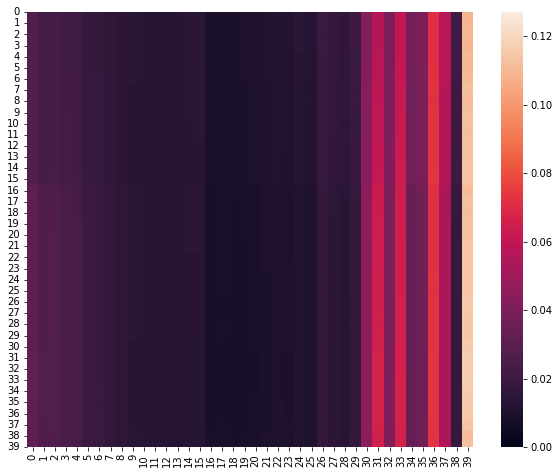

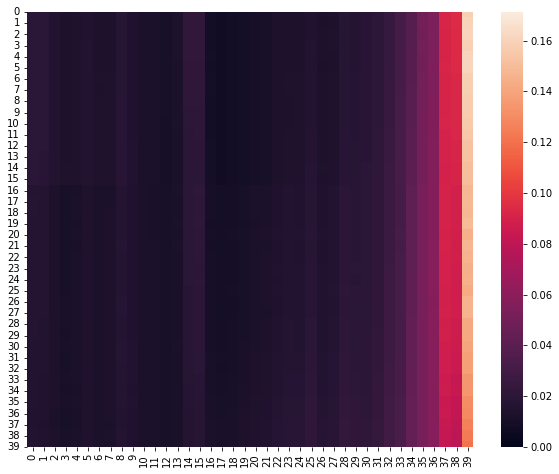

In [21]:
import seaborn as sns
for layer in [0,1]:
    plt.figure(figsize = [10,8])
    A = enc_attns[layer][0].detach().cpu().numpy()
    sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

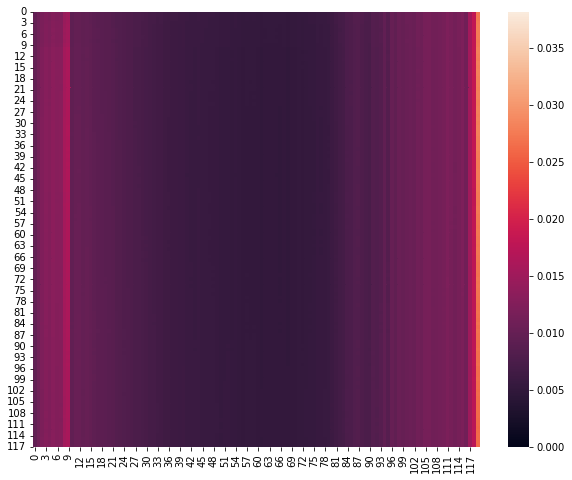

In [22]:
for layer in [0]:
    plt.figure(figsize = [10,8])
    A = dec_attns[layer][0].detach().cpu().numpy()
    sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()